In [ ]:
import json
import pandas as pd
import numpy as np  
import os

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
path = '/content/drive/MyDrive/DO_AN_KHDL/DATA'
path_audio_feats = os.path.join(path, 'audio_features.tsv')
path_playlists = os.path.join(path, 'playlists.tsv')
path_tracks = os.path.join(path, 'tracks.tsv')

In [ ]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [ ]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [ ]:
pd_full.shape

(86400, 25)

In [ ]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [ ]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [ ]:
pd_full.shape

(86350, 25)

## 1. K-means

In [ ]:
pd_playlists_top150 = pd_playlists.copy()
pd_playlists_top150 = pd_playlists_top150.sort_values(by = 'num_tracks', ascending=False)
pd_playlists_top150 = pd_playlists_top150[:150]
pd_playlists_top150.shape

(150, 5)

In [ ]:
pd_tracks_copy = pd.read_csv(path_tracks, sep = '\t')
pd_tracks_copy.head()

pd_tracks_copy = pd.merge(pd_tracks_copy, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_tracks_copy = pd_tracks_copy.drop('id', 1)

pd_playlists_top150 = pd.merge(pd_tracks_copy, pd_playlists_top150, left_on = 'playlist_id', right_on = 'playlist_id')

pd_playlists_top150 = pd_playlists_top150.drop('playlist_name_y', 1)

In [ ]:
pd_playlists_top150.columns

Index(['track_id', 'track_name', 'playlist_id', 'playlist_name_x',
       'artist_ids', 'artist_names', 'album_id', 'album_name',
       'track_duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'analysis_url', 'time_signature', 'description',
       'num_tracks', 'num_followers'],
      dtype='object')

In [ ]:
pd_playlists_numeric = pd_playlists_top150.drop(['track_id', 'track_name', 'playlist_id', 'playlist_name_x',
       'artist_ids', 'artist_names', 'album_id', 'album_name', 'description',
       'num_tracks', 'num_followers', 'analysis_url'], 1)

In [ ]:
pd_playlists_numeric.head()

,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,172324,0.736,0.802,0,-4.759,1,0.0864,0.4680,0.00000,0.0940,0.6750,144.005,4
1,214706,0.392,0.574,7,-9.195,1,0.1700,0.8330,0.00179,0.1450,0.5290,81.112,4
2,178994,0.652,0.383,2,-7.076,0,0.0516,0.0676,0.00000,0.0828,0.5490,145.765,4
3,174321,0.889,0.340,11,-7.773,0,0.0697,0.2180,0.13000,0.0550,0.7160,94.009,4
4,149297,0.631,0.239,11,-7.071,0,0.0398,0.8640,0.00000,0.1160,0.0927,79.859,4


In [ ]:
# Standardizing the data
scaler = MinMaxScaler()
scaler.fit(pd_playlists_numeric)
pd_playlists_numeric_scaled = scaler.transform(pd_playlists_numeric)

In [ ]:
pd_playlists_numeric_scaled

array([[0.03590713, 0.75178754, 0.80198388, ..., 0.67975831, 0.65545901,
        0.8       ],
       [0.04495888, 0.40040858, 0.57396532, ..., 0.5327291 , 0.36919268,
        0.8       ],
       [0.03733168, 0.6659857 , 0.38294977, ..., 0.55287009, 0.6634699 ,
        0.8       ],
       ...,
       [0.07213718, 0.7752809 , 0.27694114, ..., 0.28096677, 0.49614248,
        0.8       ],
       [0.0646172 , 0.57814096, 0.32394497, ..., 0.20241692, 0.72777093,
        0.8       ],
       [0.04707519, 0.12359551, 0.08172525, ..., 0.03655589, 0.36518723,
        0.8       ]])

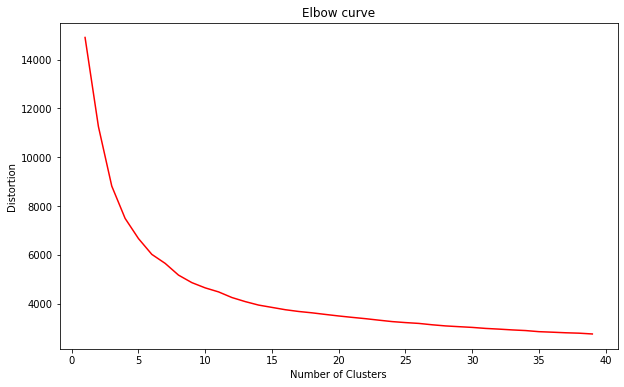

In [ ]:
distortion = []
n_clusters = 40

for k in range(1, n_clusters):  
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(pd_playlists_numeric_scaled)
    distortion.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, n_clusters), distortion, c = 'red')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow curve')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 8)
kmeans.fit(pd_playlists_numeric_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
label = kmeans.labels_
pd_playlists_numeric['cluster_label'] = label

In [ ]:
pd_playlists_numeric.sort_values

,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster_label
0,172324,0.736,0.8020,0,-4.759,1,0.0864,0.4680,0.00000,0.0940,0.6750,144.005,4,3
1,214706,0.392,0.5740,7,-9.195,1,0.1700,0.8330,0.00179,0.1450,0.5290,81.112,4,4
2,178994,0.652,0.3830,2,-7.076,0,0.0516,0.0676,0.00000,0.0828,0.5490,145.765,4,6
3,174321,0.889,0.3400,11,-7.773,0,0.0697,0.2180,0.13000,0.0550,0.7160,94.009,4,6
4,149297,0.631,0.2390,11,-7.071,0,0.0398,0.8640,0.00000,0.1160,0.0927,79.859,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14707,250285,0.100,0.1490,9,-23.935,1,0.0423,0.9440,0.95000,0.1400,0.0460,83.857,4,2
14708,328193,0.595,0.0331,5,-23.656,0,0.0331,0.9630,0.93200,0.0866,0.0602,99.999,4,7
14709,341960,0.759,0.2770,1,-14.485,1,0.0484,0.7670,0.87100,0.0834,0.2790,109.003,4,2
14710,306750,0.566,0.3240,0,-14.811,0,0.0371,0.6920,0.85500,0.0829,0.2010,159.892,4,7


## 1. Baseline model

**Phân tích biến danceability**

In [ ]:
track_name = ['Levitating (feat. DaBaby)', 'Tessanne Tell Dem']

In [ ]:
def baseline(tracks, df, n_pred):
    '''
    Input:
    1. tracks = Takes a list of track titles as input (strings)
    2. df = Dataframe containing all track info
    Output:
    recs = Recommends (n_pred) track uri based on info of that string (List of strings)
    '''
    recs = []
    for t in tracks:
        danceability = df[df['track_name'] == t]['danceability']
        df['rec_df_dance'] = np.abs(df['danceability'] - danceability.values[0])
        one_recs = list(df.sort_values(by=['rec_df_dance'])['track_name'][1:].values)
        recs = [track for track in one_recs if track not in tracks][0:n_pred]
    preds = collections.Counter(recs).most_common(n_pred)
    pred_titles = [p[0] for p in preds]
    return pred_titles

In [ ]:
result = baseline(track_name, pd_full, 10)

In [ ]:
result

['Dying in the Subtlety',
 'Cross My Mind',
 'REALiTi (Demo)',
 'Super Bass',
 "I'm Leaving You (feat. Ledisi & John Scofield)",
 'She Will Be Loved',
 'Astronaut - Something About Your Love',
 'No Mercy',
 'Tattoo - Remix with Camilo',
 'Swim']

## 2. Improvement of baseline model

In [ ]:
pd_full_copy = pd_full.copy()

In [ ]:
pd_playlists.head()

,playlist_id,playlist_name,description,num_tracks,num_followers
0,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233
1,37i9dQZF1DX0XUsuxWHRQd,Today's Top Hits,"New music from Jack Harlow, Juice WRLD and Kid...",50,13537247
2,37i9dQZF1DX1lVhptIYRda,RapCaviar,"Today's top country hits of the week, worldwid...",53,6189727
3,37i9dQZF1DX10zKzsJ2jva,RapCaviar,"Today's top Latin hits are right here, on ¡Viv...",50,10763311
4,37i9dQZF1DX4JAvHpjipBk,Hot Country,"New albums from Taylor Swift, Jack Harlow, Kid...",100,3694201


In [ ]:
pd_playlists_top50 = pd_playlists.copy()
pd_playlists_top50 = pd_playlists_top50.sort_values(by = 'num_tracks', ascending=False)
pd_playlists_top50 = pd_playlists_top50[:50]
pd_playlists_top50.shape

(50, 5)

In [ ]:
pd_tracks_copy = pd.read_csv(path_tracks, sep = '\t')
pd_tracks_copy.head()

print(pd_tracks_copy.shape)
pd_tracks_copy = pd.merge(pd_tracks_copy, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_tracks_copy = pd_tracks_copy.drop('id', 1)
print(pd_tracks_copy.shape)

pd_full_top50 = pd.merge(pd_tracks_copy, pd_playlists_top50, left_on = 'playlist_id', right_on = 'playlist_id')

pd_full_top50 = pd_full_top50.drop('playlist_name_y', 1)
pd_full_top50.head()


(86432, 9)
(86400, 22)


,track_id,track_name,playlist_id,playlist_name_x,artist_ids,artist_names,album_id,album_name,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,time_signature,description,num_tracks,num_followers
0,20McUFi8KCIVdNDLrkTDuZ,Goosebumps,37i9dQZF1DX32NsLKyzScr,Power Hour,['2o08sCWF5yyo2G4DCiT7T9'],['HVME'],49HjM8mnjS9PgYjSC03tkS,Goosebumps,163208,0.767,0.659,1,-7.429,1,0.0444,0.32500,0.000000,0.130,0.4390,124.946,https://api.spotify.com/v1/audio-analysis/20Mc...,4,Tap it back or go for a spin with these uptemp...,212,2064049
1,6f3Slt0GbA2bPZlz0aIFXN,The Business,37i9dQZF1DX32NsLKyzScr,Power Hour,['2o5jDhtHVPhrJdv3cEQ99Z'],['Tiësto'],2adSO4KU3FDjeM1PXCRDZm,The Business,164000,0.798,0.620,8,-7.079,0,0.2320,0.41400,0.019200,0.112,0.2350,120.031,https://api.spotify.com/v1/audio-analysis/6f3S...,4,Tap it back or go for a spin with these uptemp...,212,2064049
2,14ngWWxvUSnIMXgF6rzSk1,Head Shoulders Knees & Toes (feat. Norma Jean ...,37i9dQZF1DX32NsLKyzScr,Power Hour,"['4AKwRarlmsUlLjIwt38NLw', '2h6hAChW74hB9HvrNo...","['Ofenbach', 'Quarterhead', 'Norma Jean Martine']",1h2sYjn95QeTA0rSBCoke0,Head Shoulders Knees & Toes (feat. Norma Jean ...,156960,0.798,0.828,2,-5.360,1,0.1930,0.02470,0.000003,0.121,0.6000,124.962,https://api.spotify.com/v1/audio-analysis/14ng...,4,Tap it back or go for a spin with these uptemp...,212,2064049
3,1w8DxFHDDInmn5TovLKKrW,Save My Life (feat. Lovespeake),37i9dQZF1DX32NsLKyzScr,Power Hour,"['1Cs0zKBU1kc0i8ypK3B9ai', '19HFRWmRCl27kTk6Le...","['David Guetta', 'MORTEN', 'Lovespeake']",4tqrHaVlCyNSvhRD4RAvCQ,Save My Life (feat. Lovespeake),183750,0.704,0.745,11,-7.664,0,0.0448,0.00135,0.741000,0.234,0.0511,128.002,https://api.spotify.com/v1/audio-analysis/1w8D...,4,Tap it back or go for a spin with these uptemp...,212,2064049
4,7GiozRoMk95aFl1WbrDdjX,Nobody,37i9dQZF1DX32NsLKyzScr,Power Hour,"['5jAMCwdNHWr7JThxtMuEyy', '4cpqUkL78IoYnEvYj4...","['NOTD', 'Catello']",0n1BagGDuJad065Qjb7enT,Nobody,143952,0.818,0.773,8,-5.714,0,0.0579,0.01660,0.000008,0.377,0.8780,122.016,https://api.spotify.com/v1/audio-analysis/7Gio...,4,Tap it back or go for a spin with these uptemp...,212,2064049


In [ ]:
le = preprocessing.LabelEncoder()
le.fit(pd_full_top50['playlist_id'])

LabelEncoder()

In [ ]:
pd_full_top50['playlist_id_label'] = le.transform(pd_full_top50['playlist_id'])

In [ ]:
omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'time_signature', 'description', 'num_followers', 'num_tracks']

In [ ]:
pd_full_top50 = pd_full_top50.drop(omit_feats, 1)

In [ ]:
pd_full_top50.head()


,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id_label
0,163208,0.767,0.659,1,-7.429,1,0.0444,0.32500,0.000000,0.130,0.4390,124.946,24
1,164000,0.798,0.620,8,-7.079,0,0.2320,0.41400,0.019200,0.112,0.2350,120.031,24
2,156960,0.798,0.828,2,-5.360,1,0.1930,0.02470,0.000003,0.121,0.6000,124.962,24
3,183750,0.704,0.745,11,-7.664,0,0.0448,0.00135,0.741000,0.234,0.0511,128.002,24
4,143952,0.818,0.773,8,-5.714,0,0.0579,0.01660,0.000008,0.377,0.8780,122.016,24


In [ ]:
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

X = pd_full_top50.drop('playlist_id_label', 1)
y = pd_full_top50['playlist_id_label']

In [ ]:
clf.fit(X, y, verbose=True)

LGBMClassifier(bagging_fraction=0.85, boosting_type='gbdt',
               class_weight='balanced', colsample_bytree=1.0, drop_rate=0.9,
               feature_fraction=0.1, importance_type='gain', lambda_l1=5.0,
               lambda_l2=3.0, learning_rate=0.1, max_bin=255, max_depth=9,
               min_child_samples=55, min_child_weight=5.0, min_data_in_leaf=100,
               min_split_gain=0.1, min_sum_hessian_in_leaf=1, n_estimators=500,
               n_jobs=-1, num_leaves=45, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.75,
               subsample_for_bin=200000, subsample_freq=0)

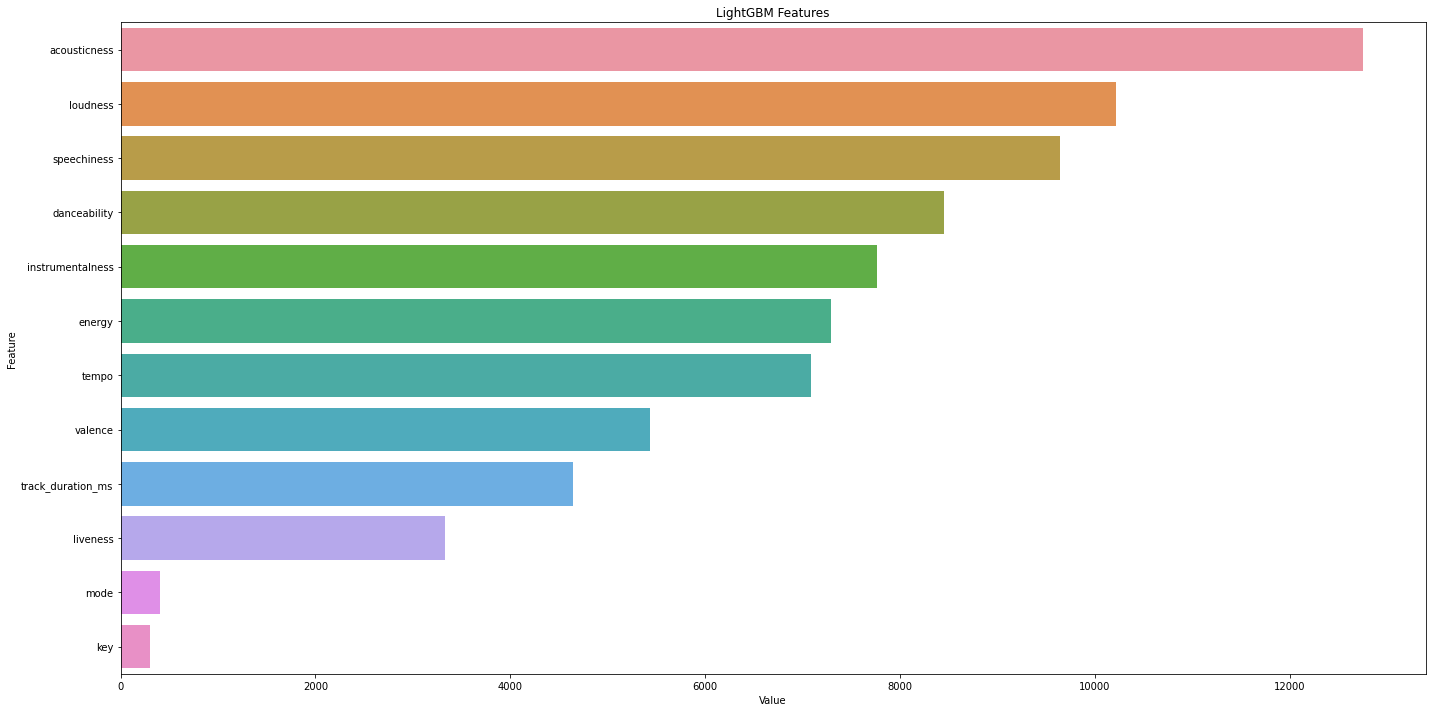

In [ ]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

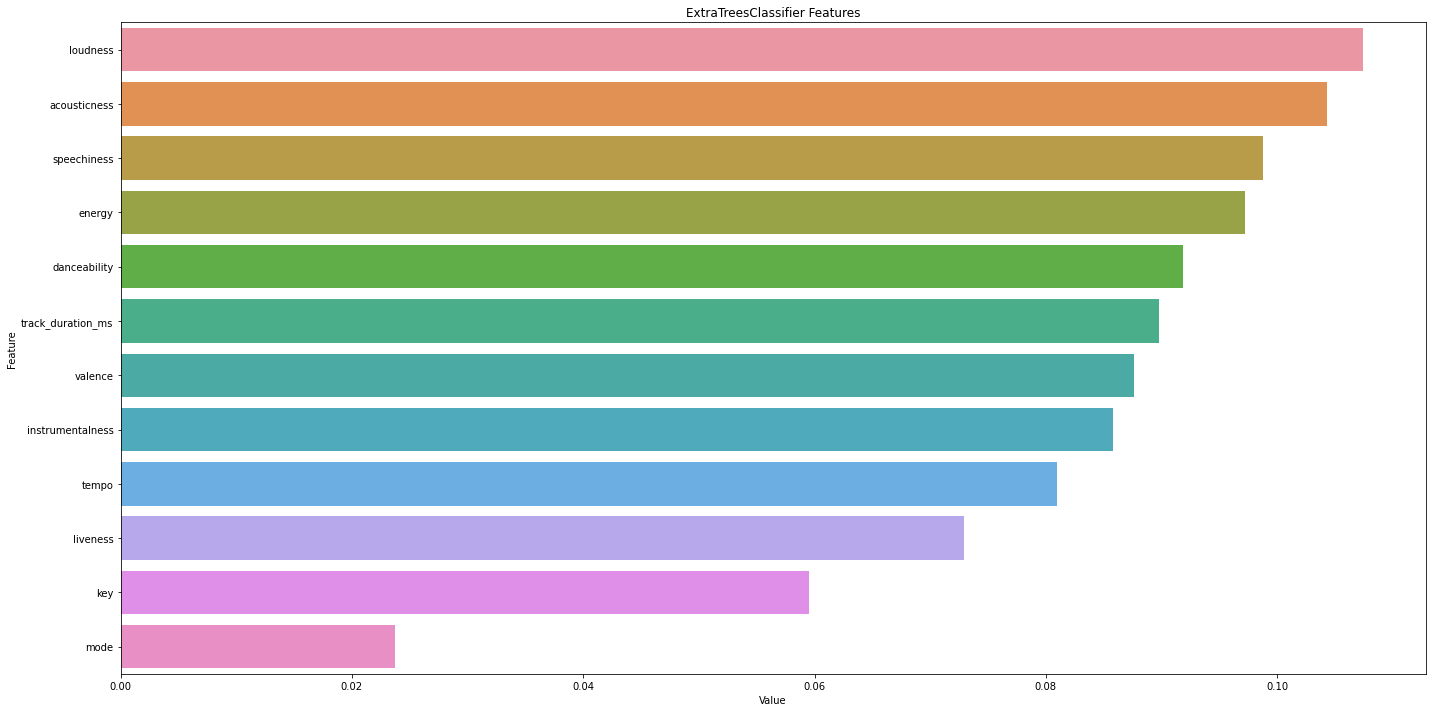

In [ ]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('ExtraTreesClassifier Features')
plt.tight_layout()
plt.show()

## Multi features

In [ ]:
X.columns

Index(['track_duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

In [ ]:
track_name = ['Levitating (feat. DaBaby)', 'Tessanne Tell Dem']
features = ['loudness', 'acousticness', 'speechiness', 'energy']

In [ ]:
def baseline(tracks, df, n_pred):
    recs = []
    for t in tracks:
        danceability = df[df['track_name'] == t]['danceability']
        df['rec_df_dance'] = np.abs(df['danceability'] - danceability.values[0])
        one_recs = list(df.sort_values(by=['rec_df_dance'])['track_name'][1:].values)
        recs.extend([track for track in one_recs if track not in tracks][0:n_pred])
  
    preds = collections.Counter(recs).most_common(n_pred)
    pred_titles = [p[0] for p in preds]
    return pred_titles

In [ ]:
result = baseline(track_name, pd_full, 10)
result

["Can't Feel My Face",
 'Power Without Greed',
 'Hot N Cold',
 "Would You Would or Would You Won't?",
 'Within',
 'Available',
 'Born 100,000 Years Ago',
 'Gone - Radio Edit',
 'Sorry - Dirty South Radio Edit',
 'Dying in the Subtlety']

In [ ]:
def multi_feats_baseline(tracks, df, n_pred, feats):
    recs = []
    for t in tracks:
        sum_feat_values = 0
        for feat in feats:
          feat_values = df[df['track_name'] == t][feat]
          sum_feat_values = sum_feat_values + np.abs(df[feat] - feat_values.values[0]) ** len(feats)

        df['rec_df_feats'] = sum_feat_values ** (1 / len(feats))
        one_recs = list(df.sort_values(by=['rec_df_feats'])['track_name'][1:].values)
        recs.extend([track for track in one_recs if track not in tracks][0:n_pred])

    preds = collections.Counter(recs).most_common(n_pred)
    pred_titles = [p[0] for p in preds]
    return pred_titles

In [ ]:
danceability = pd_full_top50['danceability']
danceability.values

array([0.767, 0.798, 0.798, ..., 0.164, 0.231, 0.187])

In [ ]:
a = 0
b = np.array([4,5,6])
a + b

array([4, 5, 6])

In [ ]:
result = multi_feats_baseline(track_name, pd_full, 10, features)

In [ ]:
result

['Last Friday Night (T.G.I.F.)',
 'All Good',
 'Better Together',
 'Thunder',
 'Blurry',
 'Stick It to the Man',
 "Ain't Right",
 'Lady Marmalade - From "Moulin Rouge" Soundtrack',
 "Runnin' (Dying To Live)",
 'Doppelganger']

In [ ]:
pd_full.head()

,track_id,track_name,playlist_id,playlist_name_x,artist_ids,artist_names,album_id,album_name,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,time_signature,description,num_tracks,num_followers,rec_df_dance,rec_df_feats
0,463CkQjx2Zk1yXoBuierM9,Levitating (feat. DaBaby),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5...","['Dua Lipa', 'DaBaby']",04m06KhJUuwe1Q487puIud,Levitating (feat. DaBaby),203064,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.00000,0.0674,0.915,102.977,https://api.spotify.com/v1/audio-analysis/463C...,4,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,0.019,1.106072
1,7igeByaBM0MgGsgXtNxDJ7,positions,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],3jqEvfiu2ENgmgzZq27zbi,positions,172324,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.00000,0.0940,0.675,144.005,https://api.spotify.com/v1/audio-analysis/7ige...,4,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,0.015,2.072903
2,0lx2cLdOt3piJbcaXIV74f,willow,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['06HL4z0CvFAxyc27GXpf02'],['Taylor Swift'],2Xoteh7uEpea4TohMxjtaq,evermore,214706,0.392,0.574,7,-9.195,1,0.1700,0.83300,0.00179,0.1450,0.529,81.112,https://api.spotify.com/v1/audio-analysis/0lx2...,4,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,0.329,6.507396
3,2Z8yfpFX0ZMavHkcIeHiO1,Monster (Shawn Mendes & Justin Bieber),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['7n2wHs1TKAczGzO7Dd2rGr', '1uNFoZAHBGtllmzznp...","['Shawn Mendes', 'Justin Bieber']",3yVVL2EYLp8g7gT08VvYKy,Monster,178994,0.652,0.383,2,-7.076,0,0.0516,0.06760,0.00000,0.0828,0.549,145.765,https://api.spotify.com/v1/audio-analysis/2Z8y...,4,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,0.069,4.388142
4,6zFMeegAMYQo0mt8rXtrli,HOLIDAY,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['7jVv8c5Fj3E9VhNjxT4snq'],['Lil Nas X'],4EvukZrmNBiqJbs3LwOSHu,HOLIDAY,154997,0.810,0.511,5,-6.924,0,0.1640,0.12000,0.00000,0.0832,0.837,151.947,https://api.spotify.com/v1/audio-analysis/6zFM...,4,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,0.089,4.236045


## Content Filtering

In [ ]:
pd_full_top50_copy = pd_full_top50.copy()

In [ ]:
pd_full_top50 = pd_full_top50.drop('playlist_id_label', 1)

In [ ]:
pd_full_top50.head()

,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,163208,0.767,0.659,1,-7.429,1,0.0444,0.32500,0.000000,0.130,0.4390,124.946
1,164000,0.798,0.620,8,-7.079,0,0.2320,0.41400,0.019200,0.112,0.2350,120.031
2,156960,0.798,0.828,2,-5.360,1,0.1930,0.02470,0.000003,0.121,0.6000,124.962
3,183750,0.704,0.745,11,-7.664,0,0.0448,0.00135,0.741000,0.234,0.0511,128.002
4,143952,0.818,0.773,8,-5.714,0,0.0579,0.01660,0.000008,0.377,0.8780,122.016


In [ ]:
# Standardizing the data
scaler = MinMaxScaler()
scaler.fit(pd_full_top50)
df_full_scaled = scaler.transform(pd_full_top50)

# We create the cosine similarity matrix of the small scaled dataframe we have 
df_full_cosine = pd.DataFrame(cosine_similarity(df_full_scaled))

In [ ]:
pd_full_top50

,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,163208,0.7670,0.6590,1,-7.429,1,0.0444,0.32500,0.000000,0.130,0.4390,124.946
1,164000,0.7980,0.6200,8,-7.079,0,0.2320,0.41400,0.019200,0.112,0.2350,120.031
2,156960,0.7980,0.8280,2,-5.360,1,0.1930,0.02470,0.000003,0.121,0.6000,124.962
3,183750,0.7040,0.7450,11,-7.664,0,0.0448,0.00135,0.741000,0.234,0.0511,128.002
4,143952,0.8180,0.7730,8,-5.714,0,0.0579,0.01660,0.000008,0.377,0.8780,122.016
...,...,...,...,...,...,...,...,...,...,...,...,...
4993,229404,0.0602,0.0873,0,-25.050,1,0.0445,0.96500,0.866000,0.107,0.0359,64.171
4994,208000,0.2330,0.2280,5,-21.068,0,0.0363,0.92200,0.941000,0.116,0.0641,96.783
4995,179793,0.1640,0.0258,10,-27.415,1,0.0374,0.95700,0.921000,0.129,0.0628,62.577
4996,199672,0.2310,0.1200,0,-20.327,0,0.0466,0.99300,0.952000,0.168,0.1110,67.950


In [ ]:
def generate_radio(tracks, cosine_df, info_df, n_pred = 10):
    recs = []
    for t in tracks:
      index = info_df.index[info_df['track_id'] == t][0]
      similarities = cosine_df.iloc[:, index].sort_values(ascending=False)
      final_indices = list(similarities[1:(n_pred + 1)].index)
      rec_songs = info_df[['track_name','track_id']].iloc[final_indices]
      recs.extend(rec_songs['track_name'].values)

    preds = collections.Counter(recs).most_common(n_pred)
    pred_titles = [p[0] for p in preds]
    return pred_titles

In [ ]:
i = [34, 60, 100, 120]

test_url = pd_full_top50_copy.iloc[i]['track_id']
print("Song provided:")
print(pd_full_top50_copy.iloc[i]['track_name'].values)

x = generate_radio(test_url, df_full_cosine, pd_full_top50_copy, 10)
print()
print("Radio recommended")
print(x)

Song provided:
['Better Off Without You (feat. Shift K3Y)' 'Mr. Brightside'
 'Starting Over' 'You']

Radio recommended
['Long Blue Light', 'Somebody New', 'Mess Is Mine', 'I Just Got 2', "When We're Gone", 'WANT', 'Dumb Litty', 'Up & Down', 'Weirdo, Pt. 2', 'Orange Trees - Claptone Remix']


## K - means